## Section 1
Sub-question: Are current solar and wind power plants in the country being predominantly built in areas of high solar and wind power potential?

1. Heatmap of Ph Regions according to Solar Potential per administrative boundary up to Barangay Level
2. Overlay the locations of wind and solar power plants in the country
3. Create histogram of # powerplants per band of wind potential per sqm

#### 1. Heatmap of Ph Regions according to Solar Potential per administrative boundary up to Barangay Level

Solar Potential

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
import xlsxwriter
from shapely.geometry import Point, Polygon
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from math import sqrt

In [2]:

# taken from https://data.humdata.org/dataset/cod-ab-phl
fp = ".\Data\Shapefiles\Philippines\phl_admbnda_adm2_psa_namria_20200529.shp"
map_df = gpd.read_file(fp)
map_df.columns
map_df = map_df[['ADM2_EN', 'geometry']]


C:\Users\rayno\AppData\Local\Temp\ipykernel_15944\981694574.py:3: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  powerplants = pd.read_csv(powerplantsfp)
c:\Program Files\Python310\lib\site-packages\pyproj\crs\crs.py:130: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


Text(247.88427187839767, 0.5, 'Latitude')

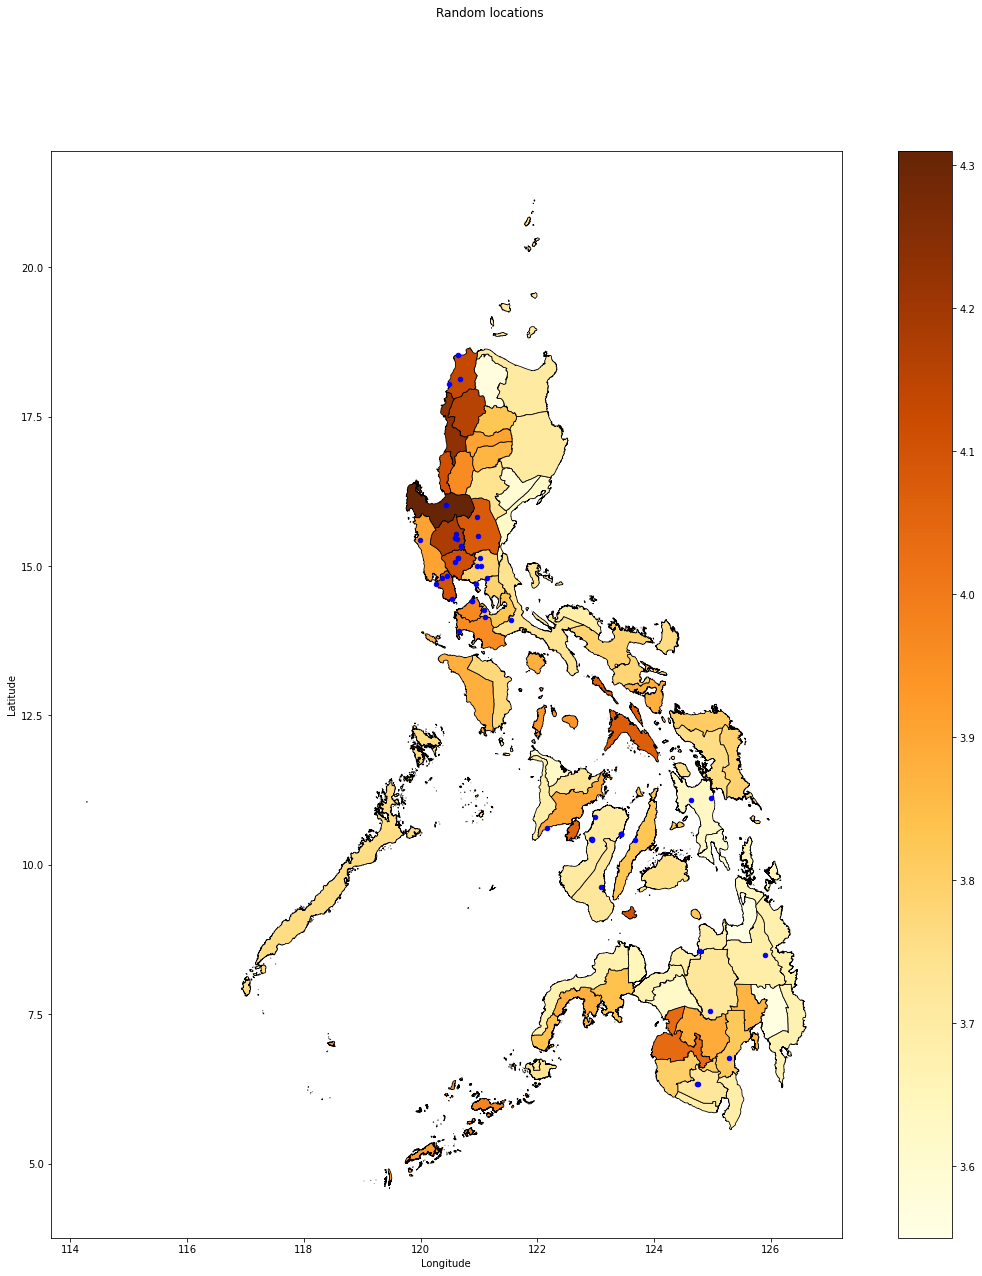

In [3]:
# Solar PowerPlants
powerplantsfp = '.\Data\PowerPlants\global_power_plant_database.csv'
powerplants = pd.read_csv(powerplantsfp)
powerplants = powerplants[powerplants.country_long == 'Philippines']
powerplants = powerplants[powerplants.primary_fuel == 'Solar']
powerplants.capacity_mw = pd.to_numeric(powerplants.capacity_mw, errors='coerce')
crs = {'init':'epsg:4326'}
geometry=[Point(xy) for xy in zip(powerplants["longitude"], powerplants["latitude"])]
geodata=gpd.GeoDataFrame(powerplants,crs=crs, geometry=geometry)

fig, ax = plt.subplots(figsize=(20,20))

# Data for Solar Potential Heatmap
datafp = '.\Data\SolarPotential\Philippine_regions_pvpotential.csv'
solar_potential_data = gpd.read_file(datafp)
solar_potential_data = solar_potential_data[["ADM2_EN", "avg_specific_pv_output"]]
solar_potential_data.avg_specific_pv_output = pd.to_numeric(solar_potential_data.avg_specific_pv_output, errors='coerce')

merged_solar = map_df.set_index("ADM2_EN").join(solar_potential_data.set_index("ADM2_EN"))
variable_solar = "avg_specific_pv_output"

merged_solar.plot(column=variable_solar, cmap="YlOrBr", linewidth=0.8, ax=ax, edgecolor='k', alpha=1, legend=True)
geodata.plot(ax=ax, color='blue', markersize=20)

fig.suptitle('Random locations', fontsize=12)
ax.set_xlabel('Longitude', fontsize=10)
ax.set_ylabel('Latitude', fontsize='medium')


A majority of solar powerplants in the Philippines have a capacity of less than 60 MW. ----Explain the Three Graphs----- -------Implement Binning-----

C:\Users\rayno\AppData\Local\Temp\ipykernel_15944\387320104.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  powerplants[variable_solar][index] = merged_solar.loc[a.index.array[0]][variable_solar]


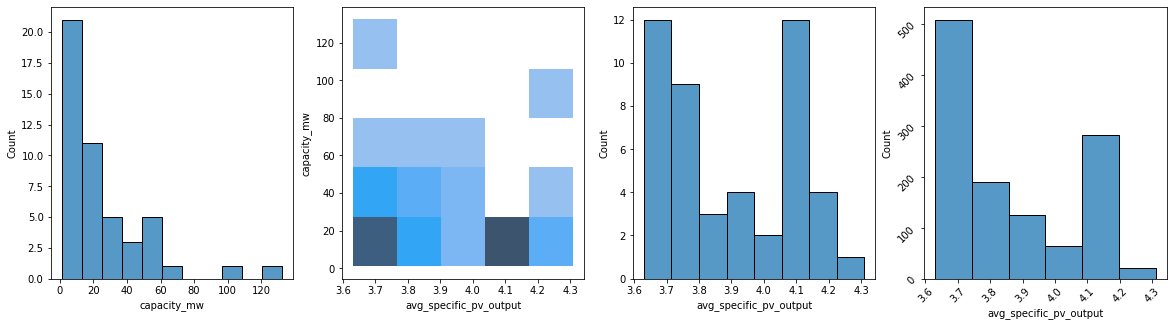

In [4]:

powerplants[variable_solar] = None
powerplants[variable_solar+"_bin"] = None       # IMPLEMENT BIN
for index, entry in powerplants.iterrows():
    a = merged_solar.geometry.contains(entry['geometry'])
    a = a[a == True]
    powerplants[variable_solar][index] = merged_solar.loc[a.index.array[0]][variable_solar]
    #IMPLEMENT BIN

fig, (h1,h2,h3,h4) = plt.subplots(1,4, figsize=(20, 5))
sns.histplot(x='capacity_mw', data=powerplants, ax=h1)
sns.histplot(x=variable_solar, y="capacity_mw", data=powerplants, bins=5, ax=h2)
sns.histplot(data=powerplants, x=variable_solar, bins=8, ax=h3)
sns.histplot(x=variable_solar,data=powerplants, weights='capacity_mw', bins=6, ax=h4)
h4.tick_params(labelrotation=45)

## Section 2

Sub-question: How much wind and solar energy is the Philippines projected to generate in the future? Can countries around the world be clustered based on solar and wind capacity, population, and GDP? If so, to which cluster does the Philippines belong, and has its cluster membership changed over time?

1. Take time-series data on [GDP, population, solar and wind capacity] per country. 
2. Perform KNN on the dataset from 1 per year, animate the result. Display in a 3D graph.
3. Highlight the Philippines performance and other notable countries in the KNN animation. Analysis.

4. Train a sequential NN on (gdp, population, cost of wind/solar power generation, cost of battery storage). 
5. Predict for coming 30 years based on projected gdp, solar/wind cost, population, and cost of battery storage)

6. Repeat 4 and 5 but on a RNN


#### KNN

In [5]:
years = ["2000","2012","2013","2014","2015","2016","2017","2018","2019"]

Installedfp = '.\Data\InstalledCapacity\RECAP_20220519-053554.csv'
Installed = pd.read_csv(Installedfp, encoding = "ISO-8859-1")
Installed = Installed[Installed.Technology == "Solar"]
Installed[years] = Installed[years].apply(pd.to_numeric, errors='coerce')

Popfp = '.\Data\PopAndGDP\Population.csv'
Pop = pd.read_csv(Popfp, encoding = "utf-8")
Pop[years] = Pop[years].apply(pd.to_numeric, errors='coerce')

GDPfp = '.\Data\PopAndGDP\GDPPerCapita.csv'
GDP = pd.read_csv(GDPfp, encoding = "utf-8")
GDP[years] = GDP[years].apply(pd.to_numeric, errors='coerce')



In [6]:
dfs = []
for year in years:
    df = pd.merge(Installed[["Country",year]], GDP[["Country",year]], on=["Country"], how='inner')
    df = pd.merge(df, Pop[["Country",year]], on=["Country"], how='inner')
    df = df.drop_duplicates()
    df.rename(columns={year+'_x':"Installed", year+'_y':"GDP", year:"Pop"}, inplace=True)
    df[["Installed", "GDP", "Pop"]] = df[["Installed", "GDP", "Pop"]].apply(pd.to_numeric, errors='coerce')
    df = df.dropna(axis=0)
    df.Installed = df.Installed/df.Pop
    dfs.append(df)
    #print(year, df.shape)

Philippine Solar Power Capacity MW Installed per year

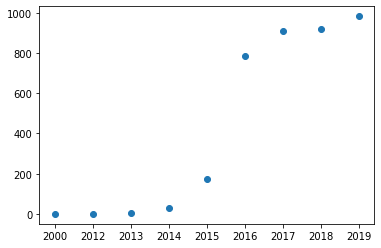

In [7]:
plt.scatter(years,np.array(Installed[Installed["Country"] == "Philippines"][years].squeeze()))

World Solar Power Capacity MW Installed per year

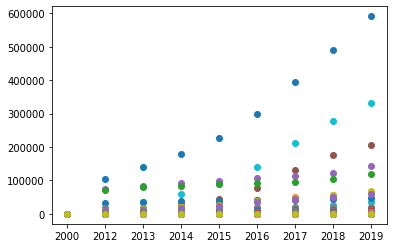

In [8]:
Installed[years] = Installed[years].apply(pd.to_numeric, errors='coerce')
for index,row in Installed.iterrows():
    #print(list(row[years]))
    #if row["Country"] in ["Philippines", "China", "United States of America"]:
    plt.scatter(years, list(row[years]))

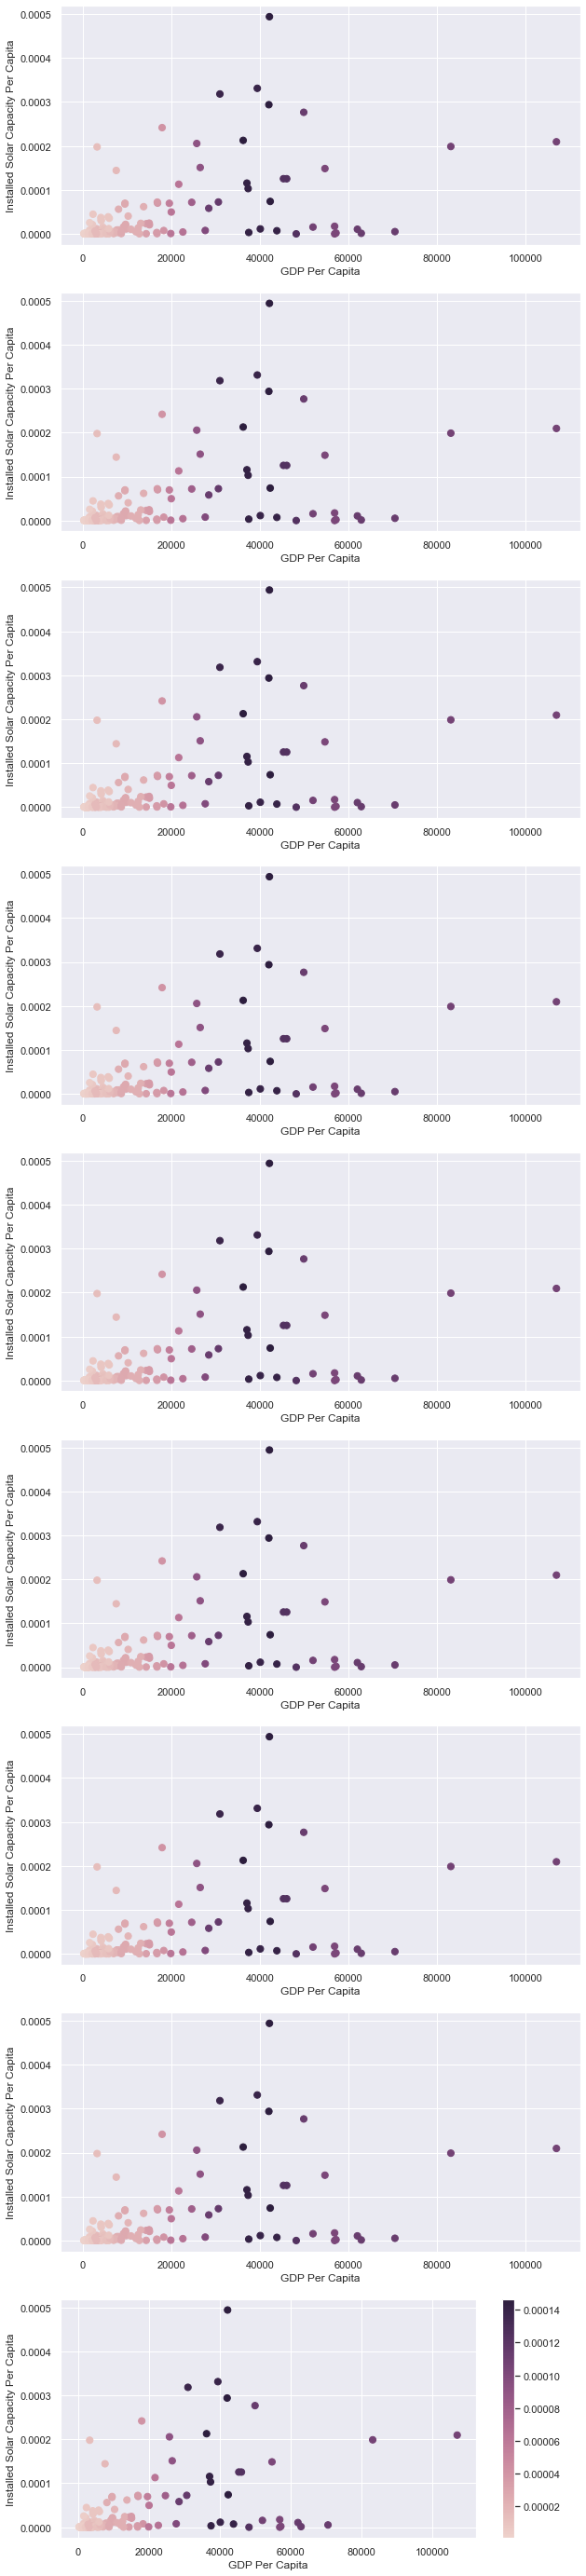

In [9]:
# 2D Plots with KNN
sns.set(style = "darkgrid")
fig, ax = plt.subplots(len(years),1,figsize=(10,50))
for i in range(len(years)):
    X = dfs[5][['GDP']]
    Y = dfs[5][['Installed']]

    parameters = {"n_neighbors": range(1,50)}
    gridsearch = GridSearchCV(KNeighborsRegressor(), parameters)
    gridsearch.fit(X, Y)

    train_preds_grid = gridsearch.predict(X)
    train_mse = mean_squared_error(Y, train_preds_grid)
    train_rmse = sqrt(train_mse)

    cmap = sns.cubehelix_palette(as_cmap=True)
    points = ax[i].scatter(X, Y, c=train_preds_grid, s=50, cmap=cmap)

    #ax[i].scatter(dfs[i].GDP, dfs[i].Installed)
    #ax[i].scatter(dfs[i][dfs[i]["Country"] == "Philippines"].GDP, dfs[i][dfs[i]["Country"] == "Philippines"].Installed, color="red")
    ax[i].set_xlabel("GDP Per Capita")
    ax[i].set_ylabel("Installed Solar Capacity Per Capita")

fig.colorbar(points)